In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#os.chdir('G:\sources\AI_based_SE\AISE_fooling')

import torch
import random
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

#from model import Model

import torch
print(torch.__version__)

debug = False

1.9.0+cu102


In [147]:
def show_image(arr):
#     if 'cuda' in str(arr.device):
#         arr = arr.cpu()
    plt.imshow(arr, cmap='gray')
    plt.show()

# TEST
# CUDA
# size = (28,28)
# a = torch.rand(size).cuda()
# show_image(a)

# CPU
if debug:
    a = torch.rand(28,28)
    show_image(a)

In [138]:
def recovery_image(image_arr, rec_type="random"):
    if rec_type == "random":
        rand_num = torch.rand(image_arr.shape)/4
        result_arr = image_arr + rand_num
    elif rec_type == "inter":    # interpolation
        kernel_arr = np.array([[0.1,0.1,0.1], [0.1,0.2,0.1], [0.1,0.1,0.1]])
        result_arr = cv2.filter2D(image_arr.detach().numpy(), -1, kernel_arr)
    result_arr[result_arr>1] = 1
    return result_arr

In [4]:
def normalize(value):
    return value * 4 // 1 / 4

In [5]:
model_path = '/mnt/g/sources/AI_based_SE/AISE_fooling/models/mnist_0.9893.pkl'
model = torch.load(model_path)
#model_cuda = torch.load(model_path).cuda()

In [160]:
def generate_initial_image(norm=False, cuda=False, size=(28,28), batch_size=1):
    if cuda:
        image_arr = torch.rand(batch_size, size[0], size[1]).cuda()
    else:
        image_arr = torch.rand(batch_size, size[0], size[1])

    if norm:
        image_arr = normalize(image_arr) # * 4 // 1 / 4
    
    return image_arr

if debug:
    # CPU
    print(generate_initial_image(norm=True, cuda=False, size=(2,2), batch_size=2))
    
    # CUDA
    #print(generate_initial_image(norm=True, cuda=True, size=(2,2), batch_size=2))

In [161]:
def polynomial_mutate(value, cuda=False, norm=False):
    strength = 15

    if cuda:
        u = torch.rand(value.shape).cuda()
        delta = torch.zeros(value.shape).cuda()
    else:
        u = torch.rand(value.shape)
        delta = torch.zeros(value.shape)

    delta[u<0.5] = (pow((u[u<0.5] * 2), (1.0 / strength + 1.0))) - 1
    delta[u>=0.5] = 1 - pow(2.0 * (1.0 - u[u>=0.5]), 1.0 / (strength + 1.0))
    
#     if u < 0.5:
#         delta = (pow((u * 2), (1.0 / strength + 1.0))) - 1
#     else:
#         delta = 1 - pow(2.0 * (1.0 - u), 1.0 / (strength + 1.0))

    delta[delta<0] = 0
    delta[delta>1] = 1
    
    if norm:
        delta = normalize(delta) # * 4 // 1 / 4
    
    result = value + delta
    return result

# TEST
if debug:
    batch_size = 64
    size = (28,28)
    # CUDA
#     a = torch.rand((batch_size, size[0], size[1]))#.cuda();
#     for i in range(5):
#         a = polynomial_mutate(a, cuda=True)
#         print(a[0][0][0])

    # CPU
    a = torch.rand((batch_size, size[0], size[1]));
    for i in range(5):
        a = polynomial_mutate(a, cuda=False)
        print(a[0][0][0])

In [150]:
def mutate(image_arr, mutate_rate, mutate_type='poly', norm=False, cuda=False, size=(28,28), batch_size=1):
    image_flatten = torch.reshape(image_arr, (batch_size * size[0] * size[1], 1))
    num_change = int(batch_size * size[0] * size[1] * mutate_rate)
    prob = torch.rand((batch_size * size[0] * size[1]))
    change_idx = torch.multinomial(prob, num_samples=num_change)
    
    if mutate_type == 'poly':
        image_flatten[change_idx] = polynomial_mutate(image_flatten[change_idx], cuda=cuda)
    if mutate_type == 'uniform':
        if cuda:
            image_flatten[change_idx] = torch.rand(len(image_flatten[change_idx]),1).cuda()
        else:
            image_flatten[change_idx] = torch.rand(len(image_flatten[change_idx]),1)
            
    image_arr = torch.reshape(image_flatten, (batch_size, size[0], size[1]))
    
    if norm:
        image_arr = normalize(image_arr)

    return image_arr

# TEST
if debug:
    batch_size = 64
    size = (28,28)
    
    # CUDA
    #a = torch.zeros(batch_size, size[0], size[1]).cuda()
    #print(mutate(a, 0.1, norm=False, cuda=True, size=size, batch_size=batch_size))
    
    # CPU - polynomial mutation
    a = torch.zeros(batch_size, size[0], size[1])
    print(a.shape, len(a[a!=0]))
    b = mutate(a, 0.1, norm=False, cuda=False, size=size, batch_size=batch_size)
    print(b.shape, len(b[b!=0]))
    
    # CPU - uniform mutation
    a = torch.zeros(batch_size, size[0], size[1])
    print(a.shape, len(a[a!=0]))
    b = mutate(a, 0.1, mutate_type='uniform', norm=False, cuda=False, size=size, batch_size=batch_size)
    print(b.shape, len(b[b!=0]))

In [151]:
def fitness_function(image_arr, label, cuda=False):
    image_arr = image_arr.unsqueeze(1)
    
    if cuda:
        predict_y = model_cuda(image_arr.float())
    else:
        predict_y = model(image_arr.float())

    #pow_ = pow(math.e, predict_y)
    #predict_y = pow_ / torch.sum(pow_)
    return predict_y[:,label]

# TEST
if debug:
    label=1
    batch_size = 64

    # CUDA
#     a = generate_initial_image(cuda=True)
#     y = fitness_function(a, 0, cuda=True)
#     show_image(a)
    
    # CPU
    a = generate_initial_image(cuda=False, batch_size=batch_size, norm=False)
    y = fitness_function(a, label, cuda=False)
    print(y.shape)
    print(f"precision : {y}")
    show_image(a[0])

In [152]:
def get_update_batches(batch_score, max_change=10):
    sorted_score, sorted_index = batch_score.sort()
    
    sorted_score = sorted_score[-max_change:]
    sorted_index = sorted_index[-max_change:]
    
    a = sorted_score!=0.0
    sorted_score = sorted_score[a]
    sorted_index = sorted_index[a]
    
    return sorted_score, sorted_index

#TEST
if debug:
    a = torch.zeros(5)
    print(get_update_batches(a, 2))

In [153]:
def get_lowest_batches(image_arr, choice_num):
    sorted_score, sorted_index = image_arr.sort()
    sorted_index = sorted_index[:choice_num]
    return sorted_index

#TEST
if debug:
    a = list(range(10))
    random.shuffle(a)
    a = torch.tensor(a)
    a_idx = get_lowest_batches(a, 3)
    print(a)
    print("idx :\t", a_idx)
    print("value :\t", a[a_idx])

In [ ]:
# MAIN code

# cuda = True
cuda = False

#norm = True
norm = False

mutate_type = 'poly'
#mutate_type = 'uniform'
########################################################

iteration = 100000
batch_size = 64 // 2 # * 16
label = list(range(0,10))

again_time = 10

best_image_arr_map_10 = torch.zeros(again_time, len(label), 28, 28)
best_score_map_10 = torch.zeros(again_time, len(label))

with torch.no_grad():
    for again in range(again_time):
        best_image_arr_map = torch.zeros(len(label), 28, 28)
        best_score_map = torch.zeros(len(label))

        print("")
        for lab in label:
            best_score = 0
            mutate_rate = 0.1
            max_score = 0
            max_copy_tag = False
            
            mutate_rate_cutting_time = 20000

            image_arr_batch = generate_initial_image(cuda=cuda, batch_size=batch_size, norm=norm)
            image_arr_score = torch.zeros(batch_size)

#             t = trange(iteration, leave=True)
#             for i in t:
            for i in range(iteration):
#             for i in tqdm(range(iteration)):
                if i % mutate_rate_cutting_time == 0:
                    mutate_rate = mutate_rate / 2

                # Mutate
                try:
                    image_arr_batch_new = mutate(image_arr_batch, mutate_rate, norm=norm, cuda=cuda, batch_size=batch_size, mutate_type=mutate_type)
                except:
                    print(iteration)

                # Fitness & sampling
                batch_score = fitness_function(image_arr_batch_new, lab, cuda=cuda)
                update_batch_score, update_batch_index = get_update_batches(batch_score)

                if len(update_batch_score) == 0:
                    continue

                # Get updated batches
                candidate_num = len(update_batch_score)
                lowest_indices = get_lowest_batches(image_arr_score, candidate_num)

                # Update batches
                image_arr_batch[lowest_indices] = image_arr_batch_new[update_batch_index]
                image_arr_score[lowest_indices] = update_batch_score

                # Get max score
                max_idx = torch.argmax(image_arr_score)
                current_max_score = image_arr_score[max_idx]

                if best_score_map[lab] < current_max_score:
                    best_score_map[lab] = current_max_score
                    best_image_arr_map[lab] = image_arr_batch[max_idx]
                    max_copy_tag = True
                    
                    # Update tqdm
                    #t.set_description(f'again : {again}, label {lab}, score : {best_score_map[lab]:2.2f}\t')
                    #t.refresh()

                if best_score_map[lab] > 99.99:
                    print(f'again : {again}, label {lab}, iter : {i}, score : {best_score_map[lab]:2.2f}')
                    break

                # Duplicate max image to batch
                if max_copy_tag:
                    max_copy_size = batch_size // 5
                    lowest_indices = get_lowest_batches(image_arr_score, max_copy_size)
                    for i in range(max_copy_size):
                        image_arr_batch[lowest_indices][i] = image_arr_batch[max_idx]
                        image_arr_score[lowest_indices][i] = image_arr_score[max_idx]
                    max_copy_tag = False

                #break  #iteration
            #show_image(best_image_arr_map[lab])
            #break  #label
            
        best_image_arr_map_10[again] = best_image_arr_map
        best_score_map_10[again] = best_score_map
        #break  #again


again : 0, label 0, iter : 1287, score : 100.03
again : 0, label 1, iter : 1646, score : 99.99
again : 0, label 2, iter : 955, score : 100.07
again : 0, label 3, iter : 839, score : 100.12
again : 0, label 4, iter : 487, score : 100.01
again : 0, label 5, iter : 898, score : 100.12
again : 0, label 6, iter : 925, score : 100.02
again : 0, label 7, iter : 897, score : 100.04
again : 0, label 8, iter : 659, score : 100.33
again : 0, label 9, iter : 596, score : 100.02

again : 1, label 0, iter : 1035, score : 100.01
again : 1, label 1, iter : 3247, score : 100.05
again : 1, label 2, iter : 963, score : 100.10
again : 1, label 3, iter : 943, score : 100.15
again : 1, label 4, iter : 520, score : 100.27
again : 1, label 5, iter : 776, score : 100.06
again : 1, label 6, iter : 920, score : 100.06
again : 1, label 8, iter : 679, score : 100.11
again : 1, label 9, iter : 562, score : 100.20

again : 2, label 0, iter : 1343, score : 100.02
again : 2, label 1, iter : 3055, score : 100.00
again

In [142]:
size = 28 * 10 + 5 * 9
full_image = torch.ones(size, size)
full_image_rec_random = torch.ones(size, size)
full_image_rec_inter = np.ones((size, size))

for a in range(10):
    for l in range(10):
        image = best_image_arr_map_10[a, l]
        pos_x = a*(28+5)
        pos_y = l*(28+5)
        full_image[pos_x:pos_x+28, pos_y:pos_y+28] = image / image.max() * 256 -1
        full_image_rec_random[pos_x:pos_x+28, pos_y:pos_y+28] = recovery_image(image) * 256 - 1 
        full_image_rec_inter[pos_x:pos_x+28, pos_y:pos_y+28] = recovery_image(image, rec_type="inter") * 256 - 1 
        
        #break
#     break

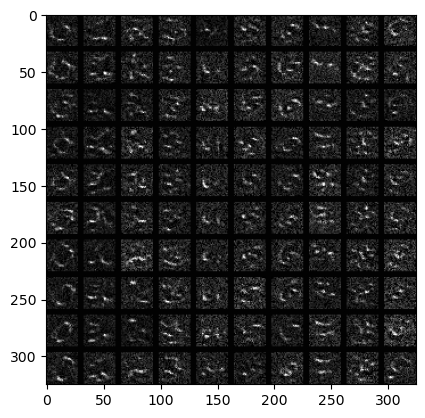

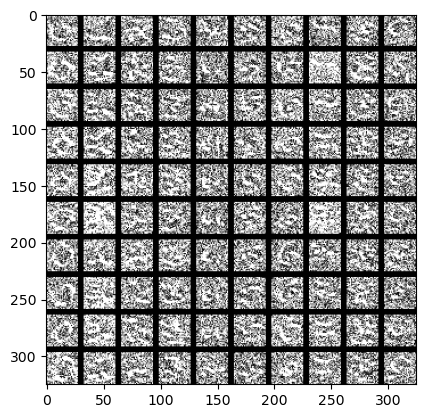

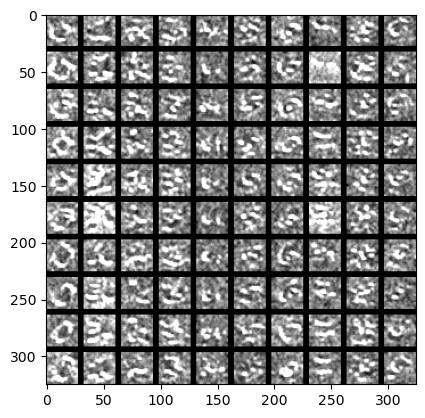

True

In [148]:
show_image(full_image)
cv2.imwrite(f'full_image.png', np.asarray(full_image, dtype=np.uint8))

show_image(full_image_rec_random)
cv2.imwrite(f'full_image_rec_random.png', np.asarray(full_image_rec_random, dtype=np.uint8))

show_image(full_image_rec_inter)
cv2.imwrite(f'full_image_rec_inter.png', np.asarray(full_image_rec_inter, dtype=np.uint8))

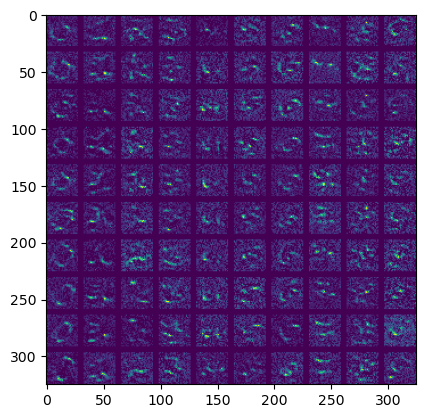

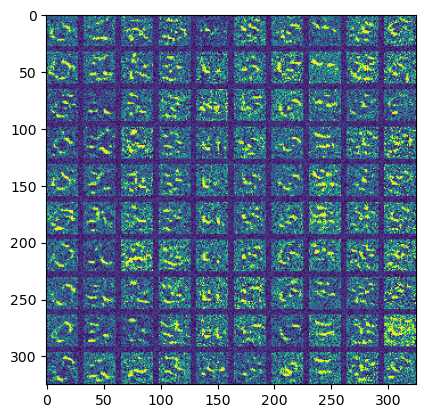

True

In [114]:
max_ = full_image[0].max()

full_image_norm = normalize(full_image/max_)
plt.imshow(full_image_norm)
plt.show()
cv2.imwrite(f'full_image_norm.png', np.asarray(a, dtype=np.uint8))

full_image_recover = recovery_image(full_image_norm)
plt.imshow(full_image_recover)
plt.show()
cv2.imwrite(f'full_image_norm.png', np.asarray(full_image_recover, dtype=np.uint8))

In [96]:
a[0].max()

tensor(0.5000)

In [ ]:
for best_image_arr_map in best_image_arr_map_10:
    for lab, best_image_arr in enumerate(best_image_arr_map):
        y = model(best_image_arr.unsqueeze(0).unsqueeze(0))
        print(y[0][lab])
        show_image(best_image_arr)

In [78]:
for lab, best_image_arr in enumerate(best_image_arr_map_10[0]):
    y = model(best_image_arr.unsqueeze(0).unsqueeze(0))
    result = y[0].detach().numpy()
    for i in range(10):
        print(f'{result[i]:3.2f}', end='\t')
    #show_image(best_image_arr)
    #cv2.imwrite(f'results/{lab}_{y[0][lab]:.2f}.png', np.asarray(best_image_arr))
    print("")

100.13	0.00	0.00	0.00	0.00	47.27	73.70	0.00	0.00	0.00	
0.00	100.03	43.71	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	0.00	100.09	5.86	0.00	0.00	0.00	0.00	2.88	0.00	
0.00	0.00	0.00	100.03	0.00	26.04	0.00	0.00	11.79	0.00	
0.00	0.00	0.00	0.00	99.99	9.71	0.00	0.00	0.00	40.50	
2.55	0.00	0.00	0.00	0.00	100.02	23.44	0.00	22.66	16.70	
42.00	0.00	0.00	1.15	0.00	41.24	100.28	0.00	0.00	0.00	
0.00	7.47	0.00	0.00	0.00	8.62	0.00	100.18	0.00	0.00	
0.00	0.00	10.94	7.79	0.00	17.73	1.90	0.00	100.14	0.00	
0.00	0.00	0.00	0.00	52.78	8.42	0.00	0.00	0.00	100.02	
